# Vehicle Detection
The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

# Load data
load data which have [vehicles](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and [not vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip) from uadcity [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/05b03f20-8c4b-453c-b41e-9fac590278c7/concepts/8c5ca570-3888-459b-9189-94cbfb8ef02c).

Then show some cars and not-cars with labels

In [112]:
import numpy as np
import cv2  #read img in BGR
import matplotlib.pyplot as plt
import matplotlib.image as mpimg #read img in RGB
import glob 

from skimage.feature import hog

%matplotlib inline

In [113]:
vehciles_images = glob.glob("train-data/vehicles/*/*/*.png")
nonvehciles_images = glob.glob("train-data/non-vehicles/*/*/*.png")
print("From the files, I know that the length fo vehicle images: ", 8792)
print("From the files, I know that the length fo nonvheicles images: ", 8968)
if len(vehciles_images)!=8792:
    print("The length fo vehicle images is not right! it is: ", len(vehciles_images))
else:
    print("The length fo vehicle images is right, it is: ", len(vehciles_images))
    
if len(nonvehciles_images)!=8968:
    print("The length fo vehicle images is not right! it is: ", len(nonvehciles_images))
else:
    print("The length fo vehicle images is right, it is: ", len(nonvehciles_images))

vehicle_img_shape = cv2.imread(vehciles_images[np.random.randint(0,len(vehciles_images))])
nonvehicle_img_shape = cv2.imread(nonvehciles_images[np.random.randint(0,len(nonvehciles_images))])
print("The shape of vheicles images: ", vehicle_img_shape.shape)
print("The shape of nonvheicles images: ", nonvehicle_img_shape.shape)

From the files, I know that the length fo vehicle images:  8792
From the files, I know that the length fo nonvheicles images:  8968
The length fo vehicle images is right, it is:  8792
The length fo vehicle images is right, it is:  8968
The shape of vheicles images:  (64, 64, 3)
The shape of nonvheicles images:  (64, 64, 3)


## show some imgs:

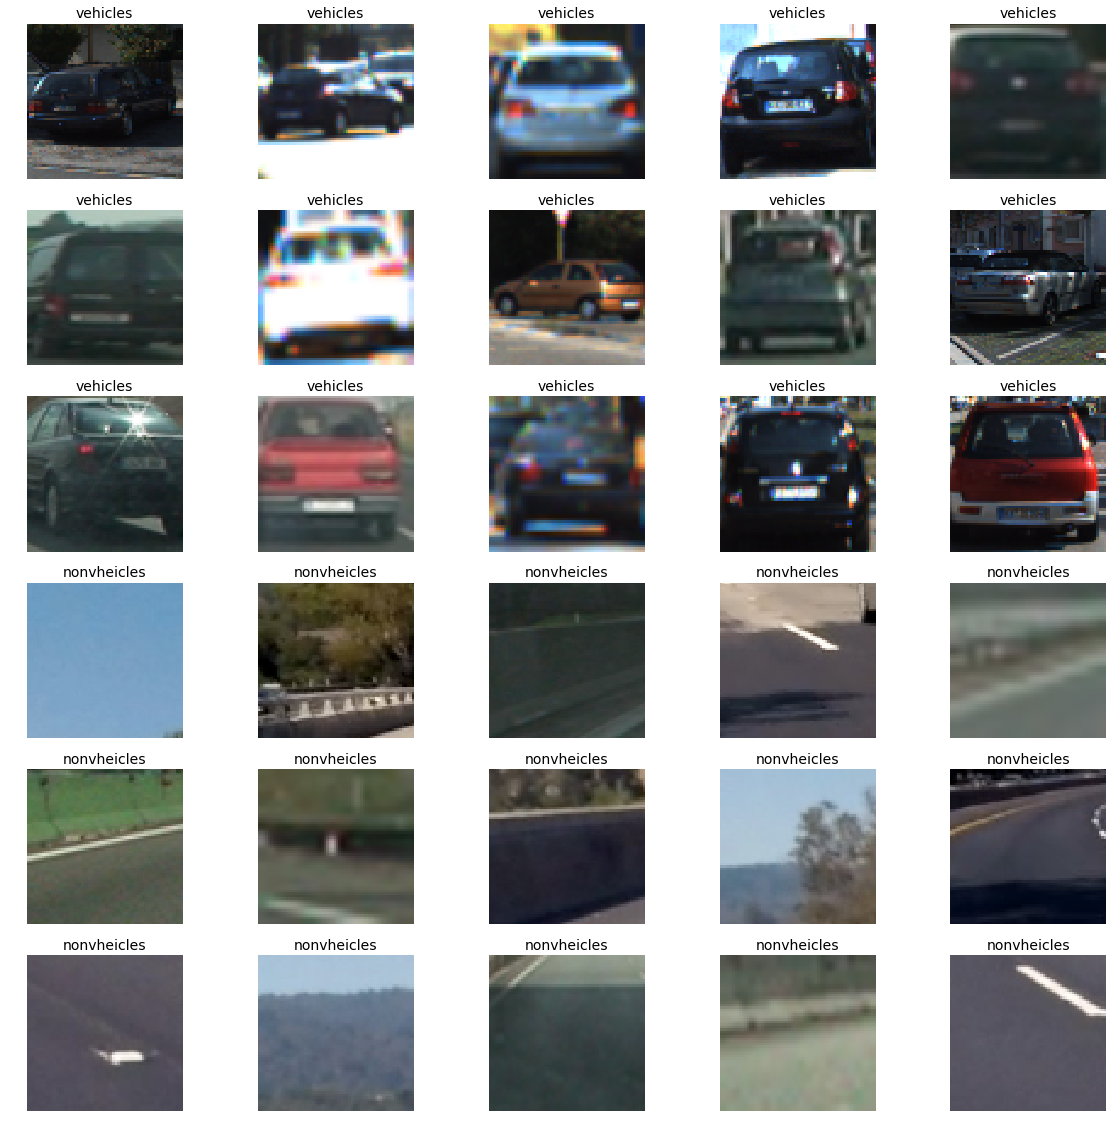

In [18]:
row = 6
col = 5
fig, axs = plt.subplots(row,col, figsize=(20, 20))
axs = axs.ravel()
for i in np.arange(row*col):
    if i < row*col/2:
        img = cv2.imread(vehciles_images[np.random.randint(0,len(vehciles_images))])
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        axs[i].axis('off')
        axs[i].set_title('vehicles', fontsize=14)
        axs[i].imshow(img)
    else:
        img = cv2.imread(nonvehciles_images[np.random.randint(0,len(nonvehciles_images))])
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        axs[i].axis('off')
        axs[i].set_title('nonvheicles', fontsize=14)
        axs[i].imshow(img)

# A Histogram of Oriented Gradients (HOG) feature extraction
Using the [scikit-image](http://scikit-image.org/) to extract Histogram of Oriented Gradient features. The documentation for this function can be found [here](http://scikit-image.org/docs/dev/api/skimage.feature.html?highlight=feature%20hog#skimage.feature.hog) and a brief explanation of the algorithm and tutorial can be found [here](http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html).

Notice:
* input shape is (64, 64, 3)
* pixels_per_cell=(8, 8)
* cells_per_block=(2, 2)
* orientations=9

In [209]:
def get_hog_features(img,orient=9, pix_per_cell=8, cell_per_block=2
                    ,vis=False,feature_vec=True):
    
    """
    return the HOG feature extraction and hog images.
    """
    if vis==True:
        hog_features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell), 
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  visualise=vis, feature_vector=feature_vec,
                                  transform_sqrt=False, 
                                  block_norm="L2-Hys")
        return hog_features, hog_image
    else: 
        
        hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell), 
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  visualise=vis, feature_vector=feature_vec,
                                  transform_sqrt=False, 
                                  block_norm="L2-Hys")
        return hog_image        
                         

## test the hog feature extraction

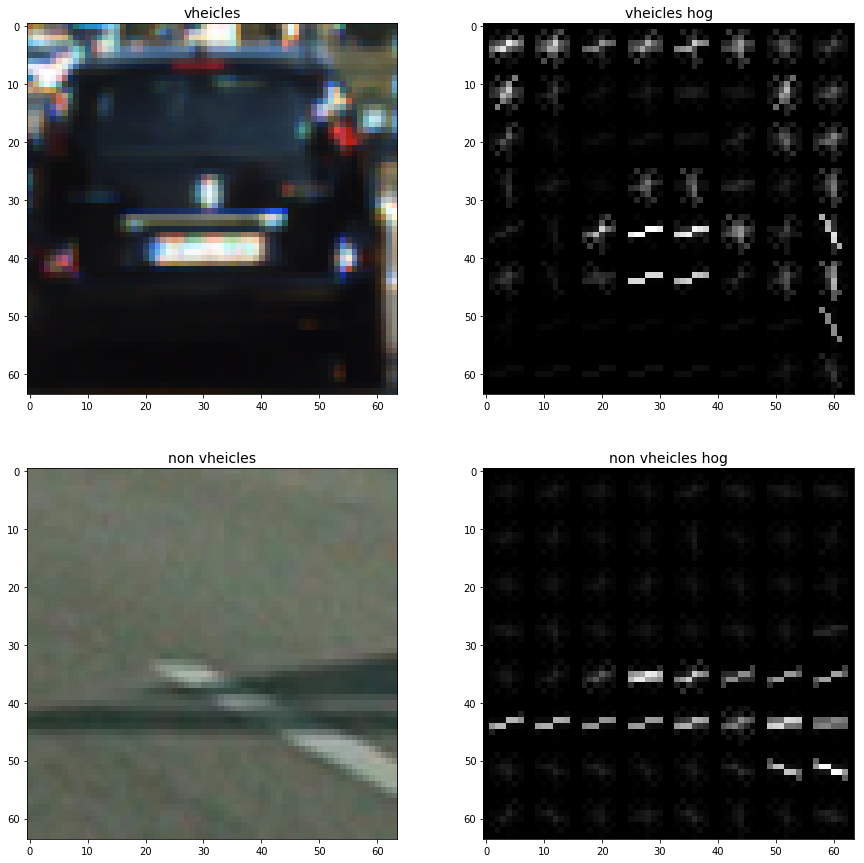

In [210]:
vehicle_img = cv2.imread(vehciles_images[np.random.randint(0,len(vehciles_images))])
nonvehicle_img = cv2.imread(nonvehciles_images[np.random.randint(0,len(nonvehciles_images))])

vehicle_img_gray = cv2.cvtColor(vehicle_img, cv2.COLOR_BGR2GRAY)
nonvehicle_img_gray = cv2.cvtColor(nonvehicle_img, cv2.COLOR_BGR2GRAY)

vehicle_features, vehicle_hog_image = get_hog_features(vehicle_img_gray, vis=True, feature_vec=False)
nonvehicle_features, nonvehicle_hog_image = get_hog_features(nonvehicle_img_gray, vis=True, feature_vec=False)

fig, axs = plt.subplots(2,2, figsize=(15, 15))
axs = axs.ravel()
axs[0].set_title('vheicles', fontsize=14)
axs[0].imshow(cv2.cvtColor(vehicle_img,cv2.COLOR_BGR2RGB))

axs[1].set_title('vheicles hog', fontsize=14)
axs[1].imshow(vehicle_hog_image, cmap='gray')

axs[2].set_title('non vheicles', fontsize=14)
axs[2].imshow(cv2.cvtColor(nonvehicle_img,cv2.COLOR_BGR2RGB))

axs[3].set_title('non vheicles hog', fontsize=14)
axs[3].imshow(nonvehicle_hog_image, cmap='gray')

# Histograms of color
from udacity [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/05b03f20-8c4b-453c-b41e-9fac590278c7/concepts/4f0692c6-e22d-4f28-b5d0-7990a4d8de86)

In [127]:
# Define a function to compute color histogram features  
def color_hist(img, show=True, nbins=32, bins_range=(0, 256)):
    """
    The input img is in RGB space
    """
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    if show:
        return rhist, ghist, bhist, bin_centers, hist_features
    else:
        return hist_features

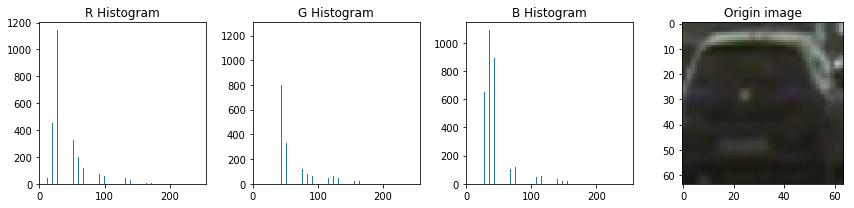

In [128]:
## show the Histograms of color
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
test_img = cv2.imread(vehciles_images[np.random.randint(0,len(vehciles_images))])
image = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
rh, gh, bh, bincen, feature_vec = color_hist(image, nbins=32, bins_range=(0, 256))

# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(141)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(142)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(143)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    plt.subplot(144)
    plt.imshow(test_img)
    plt.title('Origin image')
    fig.tight_layout()
else:
    print('Your function is returning None for at least one variable...')

# Color transform and append binned color features
from [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/05b03f20-8c4b-453c-b41e-9fac590278c7/concepts/404dfd70-937b-468f-a3df-5fb88cc2f765)

In [98]:
# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

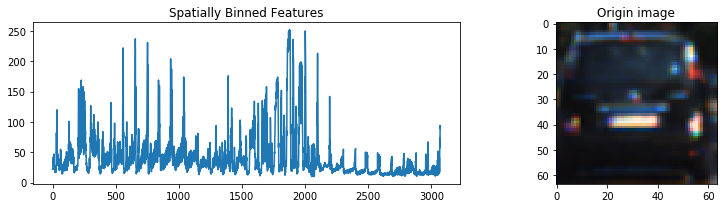

In [99]:
## test and show the spatial bining of color
test_img = cv2.imread(vehciles_images[np.random.randint(0,len(vehciles_images))])
image = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
feature_vec = bin_spatial(image, color_space='RGB', size=(32, 32))

# Plot features
fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.plot(feature_vec)
plt.title('Spatially Binned Features')
plt.subplot(122)
plt.imshow(image)
plt.title('Origin image')
fig.tight_layout()

# Apply to  HOG feature vector.
Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.


In [157]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    """
    extract feature for one img.
    Input img is in RGB space.
    """
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)


In [158]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(filenames, hog=True, spatial=False, hist=False, 
                     cspace='RGB', spatial_size=(32, 32),hist_bins=32,  
                     orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    """
    extract the features for much
    """
    features = []
    for filename in filenames:
        filefeature = []
        image = cv2.imread(filename) #in RGB color space
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        filefeature = single_img_features(image, cspace, spatial_size, hist_bins,orient,
                                         pix_per_cell,cell_per_block, hog_channel,
                                         spatial, hist, hog)
        features.append(filefeature)
    return features

# train a classifier Linear SVM classifier


In [170]:
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler


## paras!

In [ ]:
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size=(32, 32)
hist_bins=32
hog_feat = True
spatial_feat = False
hist_feat = False

In [ ]:
vehicle_features = extract_features(vehciles_images,hog=hog_feat, spatial=spatial_feat, hist=hist_feat,
                                    cspace = colorspace,spatial_size=spatial_size,hist_bins=hist_bins, 
                                    orient=orient, pix_per_cell=pix_per_cell, 
                                    cell_per_block=cell_per_block, hog_channel=hog_channel)
# nonvehicle_features = extract_features(nonvehciles_images,hog=True, spatial=False, hist=False)
nonvehicle_features = extract_features(nonvehciles_images,hog=hog_feat, spatial=spatial_feat, hist=hist_feat,
                                    cspace = colorspace,spatial_size=spatial_size,hist_bins=hist_bins, 
                                    orient=orient, pix_per_cell=pix_per_cell, 
                                    cell_per_block=cell_per_block, hog_channel=hog_channel)

In [175]:
# from sklearn.cross_validation import train_test_split
# But, if you are using scikit-learn >= 0.18 then use this:
from sklearn.model_selection import train_test_split
# Create an array stack of feature vectors
X = np.vstack((vehicle_features, nonvehicle_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(nonvehicle_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
# Fit a per-column scaler only on the training data
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X_train and X_test
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)    
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

2.9 Seconds to train SVC...
Test Accuracy of SVC =  0.9769
My SVC predicts:  [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  1.]
For these 10 labels:  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
0.00208 Seconds to predict 10 labels with SVC


YUV 9 16 2 ALL 0.9752

YUV 11 16 2 ALL  0.9789

# Implement a sliding-window technique and use your trained classifier to search for vehicles in images.


In [225]:
 # Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    """
    return slide windows.
    """
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):
    """
    return windows which find cars.
    """
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    """
    Draw box on the img
    bboxes: (((startx,starty),(endx, endy)))
    """
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, cspace, hog_channel,
              svc, X_scaler, 
              orient, pix_per_cell, cell_per_block, 
              spatial_size, hist_bins,
              color_feat=True, hog_feat=True):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)   
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    if hog_channel == 'ALL':
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    else:
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    on_windows=[]
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            if hog_channel == 'ALL':
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            
            if color_feat:
                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)) 
                # Scale features and make a prediction
            else:
                test_features = X_scaler.transform(np.hstack((hog_features)).reshape(1, -1))    
                #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                on_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return draw_img, on_windows

# create a heat map and reject outliers


In [226]:
from scipy.ndimage.measurements import label
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

# Estimate a bounding box for vehicles detected.


In [227]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# test heat map in images


length of test_imgs:  6


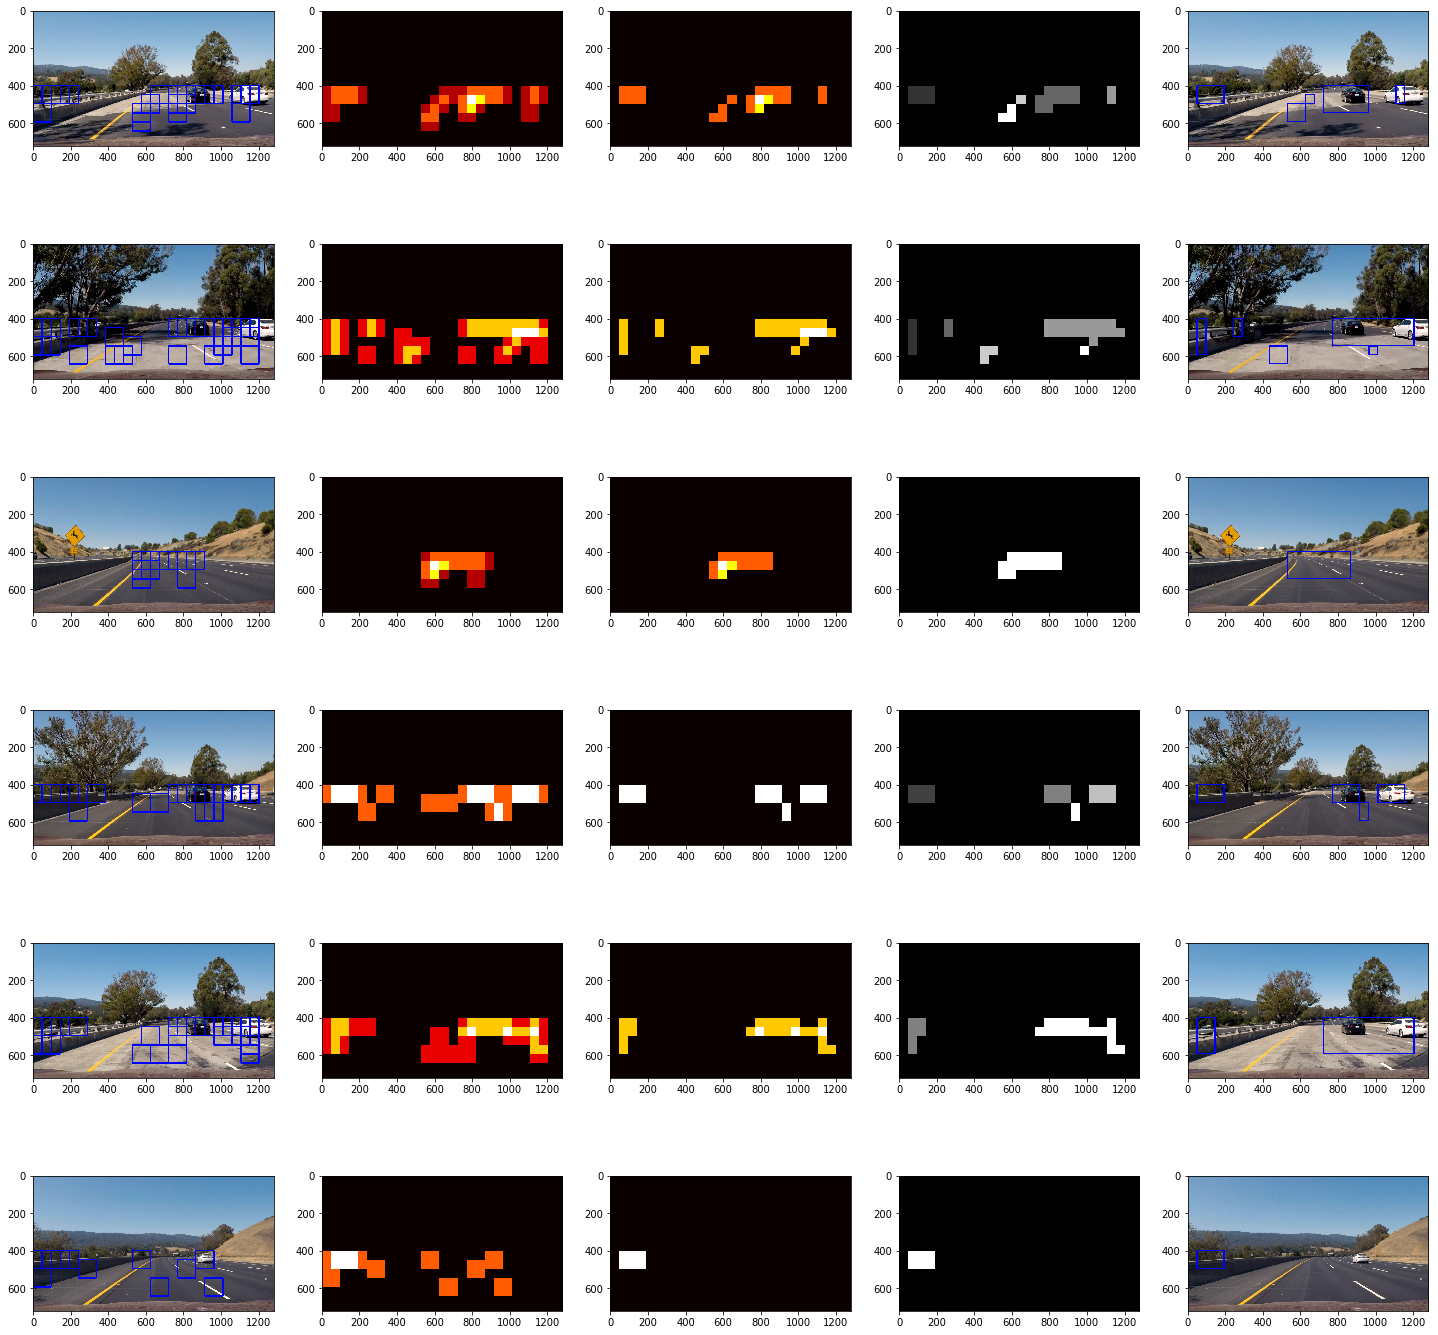

In [233]:
test_imgs = glob.glob("test_images/*.jpg")
print("length of test_imgs: ", len(test_imgs))
fig, axs = plt.subplots(len(test_imgs),5, figsize=(25, 25))
axs = axs.ravel()
x_start_stop=[600, None]
y_start_stop = [350, 656] # Min and max in y to search in slide_window()
xy_window=[128,128]
xy_overlap=[0.7,0.7]
ystart = 400
ystop = 656
scale = 1.5
colorspace = 'YUV'
hog_channel = 'ALL'
color_feat=False
hog_feat=True
i= 0
for filename in test_imgs:
    image = cv2.imread(filename) #in RGB color space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     draw_image = np.copy(image)

#     windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
#                     xy_window=xy_window, xy_overlap=xy_overlap)
#     hot_windows = search_windows(image, windows, svc, X_scaler, color_space=colorspace, 
#                         spatial_size=spatial_size, hist_bins=hist_bins, 
#                         orient=orient, pix_per_cell=pix_per_cell, 
#                         cell_per_block=cell_per_block, 
#                         hog_channel=hog_channel, spatial_feat=spatial_feat, 
#                         hist_feat=hist_feat, hog_feat=hog_feat)   
#     window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
    out_img, boxes = find_cars(image, ystart, ystop, scale, colorspace, hog_channel,
                        svc, X_scaler,
                        orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
                       color_feat, hog_feat)
    axs[i].imshow(out_img)
    i = i+1
    
    heat_img = np.zeros_like(image[:,:,0]).astype(np.float)
    heat_img = add_heat(heat_img, boxes)
    axs[i].imshow(heat_img, cmap='hot')
    i = i+1
    
    heat_img = apply_threshold(heat_img, 1)
    axs[i].imshow(heat_img, cmap='hot')
    i = i+1

    labels = label(heat_img)
    axs[i].imshow(labels[0], cmap='gray')
    i = i+1
    
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    axs[i].imshow(draw_img)
    i = i+1
    

# pipeline

In [240]:
def process_image(img):
    colorspace = 'YUV'
    hog_channel = 'ALL'
    color_feat=False
    hog_feat=True
    
    ystart = 400
    ystop = 656
    scale = 1.5
    boxes_list=[]
    out_img, boxes = find_cars(img, ystart, ystop, scale, colorspace, hog_channel,
                        svc, X_scaler,
                        orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
                       color_feat, hog_feat)
    boxes_list.append(boxes)
    # make a heat-map 
    heat_img = np.zeros_like(img[:,:,0]).astype(np.float)
    heat_img = add_heat(heat_img, boxes)
    heat_img = apply_threshold(heat_img, 1)
    
    #Using label to find the box.
    labels = label(heat_img)    
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

# Run pipeline on the video stream

In [241]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'test_video-out.mp4'
clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(lambda x: process_image(x))
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_video-out.mp4
[MoviePy] Writing video test_video-out.mp4


 97%|█████████▋| 38/39 [00:16<00:00,  2.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video-out.mp4 

CPU times: user 23.4 s, sys: 112 ms, total: 23.5 s
Wall time: 17.5 s
